In [49]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi,sqrt
from numpy import exp
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.integrate import quad

In [50]:
#param: theta, f, kappa
# rho = 2.1 
kappa_tilde = 1
f = 0.25
theta = 0.6



w_mean = theta/f

def Q_critic(list_x,f,theta,kappa_tilde): #x=w/w_mean
    
    #--------------get B----------------------
    #1- Get M_tilde via Eq. (22)
    func = lambda x: np.sum([p_eps(eps) * eps * (G(-kappa_tilde + eps*f*x) - (-kappa_tilde + eps*f*x)*H(-kappa_tilde + eps*f*x))  for eps in [-1,1]])
    M_tilde_initial_guess = 0.5
    M_tilde = fsolve(func, M_tilde_initial_guess)
    # Plot it
#     absc = np.linspace(-0.5, 100, 10000)
#     plt.plot(absc, [func(el) for el in absc])
#     plt.xlabel("M_tilde")
#     plt.ylabel("expression value")
#     plt.grid()
#     plt.show()
#     print("The solution is M_tilde = %f" % M_tilde)
#     print("at which the value of the expression is %f" % func(M_tilde))
    
    #2-Get tau from eps
    def tau(eps): #Eq. (15)
        return -kappa_tilde + eps*f*M_tilde
    
    #3- Get B via Eq. (27)
    func = lambda x: ((1+x**2)*H(x)-x*G(x))/H(x) - \
                    np.sum([(f*eps + (1-eps)/2) * H(eps) for eps in [-1,1]]) / \
                            np.sum([(f*eps + (1-eps)/2) * ((1+tau(eps)**2)* H(tau(eps)) - tau(eps)*G(tau(eps))) for eps in [-1,1]])
    B_initial_guess = 0.5
    B = fsolve(func, B_initial_guess)
    # Plot it
#     absc = np.linspace(-0.5, 100, 10000)
#     plt.plot(absc, [func(el) for el in absc])
#     plt.xlabel("B")
#     plt.ylabel("expression value")
#     plt.grid()
#     plt.show()
    print("The solution is B = %f" % B)
#     print("at which the value of the expression is %f" % func(B))
    
    #-----------------------------------------
    
    #Get w_s
    w_s = get_w_s(B,w_mean)
    
    #Return Q(x) where x = w/w_mean
    return [H(-B) * (x==0) + 1/(sqrt(2*pi) * w_s) * exp(-1/(2* w_s**2) * (w_mean*x + B * w_s)**2) * (x>0) for x in list_x]

def get_w_s(B,w_mean):
    return w_mean / (G(B) - B*H(B))
  
def H(x):
    return 1 - norm.cdf(x, loc=0, scale=1)

def G(x):
    return exp(-x**2/2)/sqrt(2*pi)
    
def p_eps(eps): #returns f if eps = 1, and 1-f if eps = -1
    return f*eps + (1-eps)/2


The solution is B = 1.146774


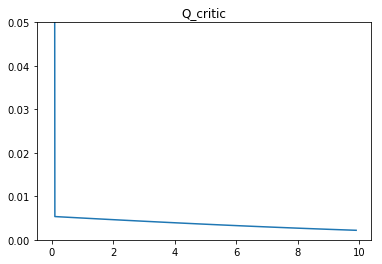

In [51]:
list_w = [i/10 for i in range(100)]
plt.plot(list_w,Q_critic(list_w,f,theta,kappa_tilde) )
plt.title('Q_critic')
plt.ylim(0,0.05)
plt.show()

In [52]:


# func = lambda x: np.sum([(f*eps + (1-eps)/2) * eps * (G(-kappa_tilde + eps*f*x) - (-kappa_tilde + eps*f*x)*H(-kappa_tilde + eps*f*x))  for eps in [-1,1]])


# # Plot it
# x = np.linspace(-0.5, 100, 10000)
# plt.plot(x, [func(el) for el in x])
# plt.xlabel("x")
# plt.ylabel("expression value")
# plt.grid()
# plt.show()

# # Use the numerical solver to find the roots

# x_initial_guess = 0.5
# x_solution = fsolve(func, x_initial_guess)

# print("The solution is x = %f" % x_solution)
# print("at which the value of the expression is %f" % func(x_solution))

# Cavity method (not from our article)

In [102]:
#Based on http://www.cell.com/neuron/fulltext/S0896-6273(04)00528-8
#with its annex http://www.cell.com/cms/attachment/572560/4239133/mmc1.pdf



def y_2(B):
    return (G(B)-B*H(B)) / sqrt((1+B**2)*H(B) - B*G(B))

def get_z_as_y(y):
    func = lambda z: f*(G(-y+z) - (-y+z)*H(-y+z)) - (1-f)*(G(-y-z) - (-y-z)*H(-y-z))
    z_value_initial_guess = 0
    z_value = fsolve(func, z_value_initial_guess)
#     #Plot it
#     absc = np.linspace(-2, 2, 100)
#     plt.plot(absc, [func(el) for el in absc])
#     plt.xlabel("z")
#     plt.grid()
#     plt.show()
#     print("The solution is z_value = %f" % z_value)
#     print("at which the value of the expression is %f" % func(z_value))
#     print(z_value)
    return z_value

def F_1(y):
    z = get_z_as_y(y)
    return (f*H(-y+z) + (1-f)*H(-y+z)) / \
        (f*((1+(-y+z)**2)*H(-y+z) - (-y+z)*G(-y+z)) +\
         (1-f)*((1+(-y-z)**2)*H(-y-z) - (-y-z)*G(-y-z)))
         
def y_1(B): 
    image = 1 + B**2 - B*G(B)/H(B)
    func = lambda y: F_1(y) - image  #Computing the invert of F_1
    y_1_initial_guess = 0
    y_1_value = fsolve(func, y_1_initial_guess)
#     #Plot it
#     absc = np.linspace(-2, 2, 100)
#     plt.plot(absc, [func(el) for el in absc])
#     plt.xlabel("B")
#     plt.grid()
#     plt.show()
#     print("The solution is y_1_value = %f" % y_1_value)
#     print("at which the value of the expression is %f" % func(y_1_value))
    return y_1_value

def rho_from_B(B):
    return y_1(B) / y_2(B)

# B_list = np.linspace(0, 5, 100)
# plt.plot(B_list, [rho_from_B(el) for el in B_list])
# plt.show()


def B_from_rho(rho_value):
#     print("Checkpoint 1")
    func_b = lambda B: rho_value - rho_from_B(B)
#     print("Checkpoint 3")
    B_initial_guess = 0
#     print("Checkpoint 4")
    B_value = fsolve(func_b, B_initial_guess)
#     #Plot it
#     absc = np.linspace(-2, 2, 100)
#     plt.plot(absc, [func_b(el) for el in absc])
#     plt.xlabel("B")
#     plt.grid()
#     plt.show()
    print("The solution is B_value = %f" % B_value)
#     print("at which the value of the expression is %f" % func_b(B_value))
#     print("Checkpoint 5")
#     print(B_value)
    return B_value

def get_alpha_c(B,y,z):
    tau_minus = -y+z
    tau_plus = -y-z
    return H(B) / (f*H(tau_minus) + (1-f)*H(tau_plus))


def get_W_s(B):
    return (theta/f) / (G(B) - B*H(B)) #W_mean = theta/f

def get_p(W,B):
    W_s = get_W_s(B)
    return H(-B)*(W==0)  + \
        1/(sqrt(2*pi) * W_s) * exp(-1/(2* W_s**2) * (W + B * W_s)**2) * (W>0)



In [126]:

#Parameters
N = 800
f = 0.25
theta_prime = 3 #theta of the 1st article = theta_2/N (where theta_2 is from the 2nd article)
theta = N*theta_prime #i.e. T of our article
theta = 0.2
rho_exp_list = [0,1,2,3]



proba_all = []
for rho_exp in rho_exp_list:
    print("--------------Rho = "+str(rho_exp)+"------------------")
    B = B_from_rho(rho_exp)
    print("B =",B)
    print("Fraction of strictly positive synapses: H(B) =",H(B))
    print("Fraction of silent synapses: H(-B) =",H(-B))
    y = y_1(B)
    print("y",y)

    # kappa_tilde = y*sqrt(N)
    # print("kappa_tilde =",kappa_tilde)
    # list_w = [i/10 for i in range(100)]
    # plt.plot(list_w,Q_critic(list_w,f,theta,kappa_tilde) )
    # plt.title('Q_critic')
    # plt.show()

    z = get_z_as_y(y)
    alpha_c = get_alpha_c(B,y,z)
    print("alpha_c =",alpha_c)

    absc = np.linspace(0,10,1000)
    proba = [get_p(x*theta/f,B) for x in absc] #x=w/w_mean=W/W_mean  where W_mean = theta/f
    proba_all.append(proba)

--------------Rho = 0------------------
The solution is B_value = -0.580318
B = [-0.58031782]
Fraction of strictly positive synapses: H(B) = [ 0.71914984]
Fraction of silent synapses: H(-B) = [ 0.28085016]
y [ -7.45159625e-17]
alpha_c = [ 1.73018146]
--------------Rho = 1------------------
The solution is B_value = 0.062007
B = [ 0.06200691]
Fraction of strictly positive synapses: H(B) = [ 0.47527866]
Fraction of silent synapses: H(-B) = [ 0.52472134]
y [ 0.54816396]
alpha_c = [ 0.80881635]
--------------Rho = 2------------------
The solution is B_value = 0.478189
B = [ 0.47818868]
Fraction of strictly positive synapses: H(B) = [ 0.31625796]
Fraction of silent synapses: H(-B) = [ 0.68374204]
y [ 0.87561947]
alpha_c = [ 0.46862752]
--------------Rho = 3------------------
The solution is B_value = 0.761362
B = [ 0.76136214]
Fraction of strictly positive synapses: H(B) = [ 0.2232204]
Fraction of silent synapses: H(-B) = [ 0.7767796]
y [ 1.08999349]
alpha_c = [ 0.30846764]


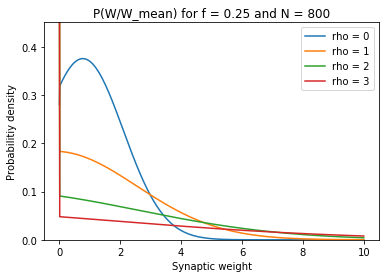

In [128]:
for i in range(len(rho_exp_list)):
    plt.plot(absc,proba_all[i],label="rho = "+str(rho_exp_list[i]))
plt.legend()
# plt.ylim(0,0.00000000005)
y_max_plot = np.max(proba_all[0][1:])
plt.ylim(0,y_max_plot*1.2)
plt.title('P(W/W_mean) for f = '+str(f)+' and N = '+str(N))
plt.ylabel('Probabilitiy density')
plt.xlabel('Synaptic weight')
plt.show()

In [130]:
#Get Figure 2 of our article

#Parameters
N = 800
f_list = [0.01,0.1,0.25,0.5]
theta_prime = 3 #theta of the 1st article = theta_2/N (where theta_2 is from the 2nd article)
theta = N*theta_prime #i.e. T of our article
theta = 0.2
rho_exp_list = np.linspace(0,5,40)

connection_proba = []
for f in f_list:
    print("f =",f)
    connection_proba_f = []
    for rho_exp in rho_exp_list:
        B = B_from_rho(rho_exp)
#         print("Fraction of strictly positive synapses: H(B) =",H(B))
        connection_proba_f.append(H(B))
    connection_proba.append(connection_proba_f)

f = 0.01


/home/vincent/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The solution is B_value = -4.168032
The solution is B_value = -3.859390
The solution is B_value = -3.579459
The solution is B_value = -3.326733
The solution is B_value = -3.099147
The solution is B_value = -2.894295
The solution is B_value = -2.709655
The solution is B_value = -2.542771
The solution is B_value = -2.391370
The solution is B_value = -2.253426
The solution is B_value = -2.127177
The solution is B_value = -2.011114
The solution is B_value = -1.903955
The solution is B_value = -1.804616
The solution is B_value = -1.712179
The solution is B_value = -1.625864
The solution is B_value = -1.545009
The solution is B_value = -1.469045
The solution is B_value = -1.397483
The solution is B_value = -1.329900
The solution is B_value = -1.265929
The solution is B_value = -1.205246
The solution is B_value = -1.147571
The solution is B_value = -1.092652
The solution is B_value = -1.040269
The solution is B_value = -0.990225
The solution is B_value = -0.942344
The solution is B_value = -0

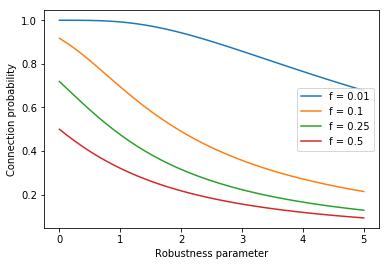

In [131]:
for i in range(len(connection_proba)):
    plt.plot(rho_exp_list,connection_proba[i],label="f = "+str(f_list[i]))
plt.legend()
# plt.ylim(0,0.00005)
# y_max_plot = np.max(proba_all[0][1:])
# plt.ylim(0,y_max_plot*1.2)
plt.ylabel('Connection probability')
plt.xlabel('Robustness parameter')
# plt.title('Connection probability (i.e. P(W_ij) > 0), for N = '+str(N))
plt.show()

# Joint distribution of weights

In [54]:
def get_lambda_value(B):
    y = y_1(B)
    z = get_z_as_y(y)
    
    def tau_eps(eps):
        if eps == 1: #tau_minus
            return -y+z
        if eps == -1: #tau_plus
            return -y-z
    num = (np.sum([p_eps(eps)*eps*(G(eps) - tau_eps(eps)*H(tau_eps(eps))) for eps in [-1,1]]))**2
    denom = 4*f*(1-f) * np.sum([p_eps(eps) * ((1+tau_eps(eps)**2)*H(tau_eps(eps)) - tau_eps(eps)*G(tau_eps(eps))) \
                                for eps in [-1,1]])
    return num/denom

def joint_distrib(w_ij,w_ji,lambda_value,B,w_s):
    
    S = 0
    
    if w_ij*w_ji == 0:
        func = lambda z: 1/sqrt(2*pi) * exp(-1/2 * z**2) * H(-(B+z*sqrt(lambda_value))/sqrt(1-lambda_value))
        I = quad(func, -np.inf, +np.inf)[0]
#         print(I)
        S += I
        
    def term_2(w):
        return 1/(sqrt(2*pi) * w_s) * exp(-1/2*(B+w/w_s))*\
            H(-sqrt((1-lambda_value)/(1+lambda_value))*B + lambda_value/sqrt(1-lambda_value**2)*w/w_s)
    if w_ji > 0 and w_ij == 0:
        S += term_2(w_ji)
    if w_ij > 0 and w_ji == 0:
        S += term_2(w_ij)
    
    if w_ij > 0 and w_ji > 0:
        term_3 = 1/(2*pi*sqrt(1-lambda_value**2)) * \
            exp(-1/(2*(1-lambda_value**2)) * ((B+w_ij/w_s)**2 + (B+w_ji/w_s)**2 - 2*lambda_value * (B+w_ij/w_s) * (B+w_ji/w_s)) )
        S += term_3
        
    return S

rho = 6.531972647421808
The solution is B_value = 1.321550
(1000, 1000)


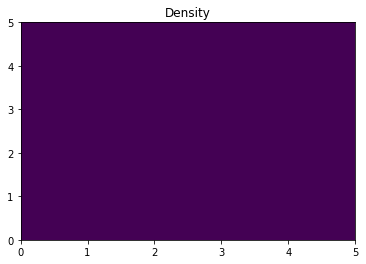

In [154]:
f = 0.25
N = 800
theta = 2 #theta is the one of our article

T = N*theta
K = 0.4*T
w_mean = theta/f


def get_rho(f,N,w_mean,K):
    return K/(w_mean*sqrt(f*(1-f)*N))
rho = get_rho(f,N,w_mean,K)
print("rho = "+str(rho))

B = B_from_rho(rho)
w_s = get_w_s(B,w_mean)


lambda_value = get_lambda_value(B)

connection_joint = []
linspace_w = np.linspace(0,5,1000)
X,Y = np.meshgrid(linspace_w,linspace_w) #X=w_ij, Y=w_ji
Z = []
for w_ij in linspace_w:
    Z_absc = []
    for w_ji in linspace_w:
        Z_absc.append(joint_distrib(w_ij,w_ji,lambda_value,B,w_s))
    Z.append(Z_absc)
Z = np.array(Z)

print(Z.shape)

# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.title('Density')
plt.show()

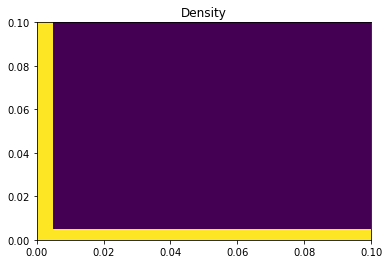

In [155]:
# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.xlim(0,0.1)
plt.ylim(0,0.1)
plt.title('Density')
plt.show()

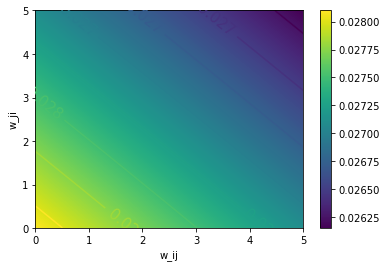

In [156]:
#Without the axes

init = 1
X_prime = np.copy(X[init:,init:])
Y_prime = np.copy(Y[init:,init:])
Z_prime = np.copy(Z[init:,init:])

# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X_prime,Y_prime,Z_prime)
plt.colorbar()
# plt.xlim(0,0.1)
# plt.ylim(0,5
# plt.title('Density')

CS = plt.contour(X_prime, Y_prime, Z_prime)
plt.clabel(CS, inline=1, fontsize=15,color='b')
plt.xlabel('w_ij')
plt.ylabel('w_ji')
plt.show()

In [60]:
#AFFICHAGE



#-----------Contour (traits pas pleins) de la densité de points---------------------------


# #Contour plot of the density
# side_x = np.linspace(np.min(chain_X[:,0]),np.max(chain_X[:,0]),1000)
# side_y = np.linspace(np.min(chain_X[:,1]),np.max(chain_X[:,1]),1000)
# X,Y = np.meshgrid(side_x,side_y)
# Z = target(X,Y)
# CS = plt.contour(X, Y, Z)
# plt.clabel(CS, inline=1, fontsize=15)

# plt.title('Original f density (contour plot) with samples from the algorithm WITH ADAPTATION')
# plt.show()


#---------------Plotter une densité (pas des points, mais une formule)------------------------

# # Sample data
# side_x = np.linspace(-5,5,1000)
# side_y = np.linspace(0,5,1000)
# X,Y = np.meshgrid(side_x,side_y)
# print(X.shape)
# # Z = np.exp(-((X-1)**2+Y**2))

# def f(x,y):
#     return 4/(2*pi) * y**1.5 * np.exp(-y * (x**2/2 + 2)) * (y>=0)

# Z = f(X,Y)
# print(Z.shape)

# # Plot the density map using nearest-neighbor interpolation
# plt.pcolormesh(X,Y,Z)
# plt.title('Original f density')
# plt.show()


#------------------Faire un graphe de type densité avec juste des points------------------------

# plt.hist2d(chain_x, chain_y, bins=50,range=np.array([[-5,5],[0,5]]))
# plt.colorbar()
# plt.title('Sampled density from Gibbs sampler')
# plt.show()

In [115]:
a = np.ones((5,5))
np.fill_diagonal(a,0)
print(a)

[[ 0.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.]
 [ 1.  1.  0.  1.  1.]
 [ 1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  0.]]
